# Data Coverage and Count of Null Values
Exploring the NYC Building Elevation and Subgrade (BES) Dataset in Python

Author: Mark Bauer

In [1]:
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
# Printing verions of Python modules and packages with **watermark** - the IPython magic extension.
%reload_ext watermark
%watermark -v -p duckdb,geopandas,matplotlib

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb    : 1.0.0
geopandas : 0.12.1
matplotlib: 3.6.2



![cover-photo](images/dataset-cover-photo.png)
Screenshot of dataset on NYC Open Data.

Link to dataset website: https://data.cityofnewyork.us/City-Government/Building-Elevation-and-Subgrade-BES-/bsin-59hv

# Create DuckDB database instance

In [3]:
# create a DuckDB database instance
con = duckdb.connect()

# examine count of rows
con.sql(
    """
    SELECT COUNT(*) AS count_rows
    FROM read_parquet('data/bes-data.parquet')
    """
).show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     861876 │
└────────────┘



# Load data and convert to a pandas dataframe

In [4]:
# explore data as a dataframe
df = con.sql("SELECT * FROM read_parquet('data/bes-data.parquet')").df()

rows, cols = df.shape
print(f"rows: {rows:,}\ncolumns: {cols}")

# preview data
df.head()

rows: 861,876
columns: 26


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


# Preview data

In [5]:
# is identification number unique
is_unique = df['bin'].is_unique

print(f"Building Identification Number (BIN) field is unique: {is_unique}")

Building Identification Number (BIN) field is unique: True


In [6]:
# preview datatypes and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861876 entries, 0 to 861875
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   the_geom    861876 non-null  object 
 1   bin         861876 non-null  int64  
 2   bbl         861876 non-null  int64  
 3   borough     861875 non-null  float64
 4   block       861875 non-null  float64
 5   lot         861876 non-null  int64  
 6   address     844875 non-null  object 
 7   z_grade     861876 non-null  float64
 8   z_floor     861876 non-null  float64
 9   subgrade    861876 non-null  object 
 10  notes1      861876 non-null  object 
 11  notes2      202458 non-null  object 
 12  notes3      472003 non-null  object 
 13  x           861876 non-null  float64
 14  y           861876 non-null  float64
 15  latitude    861876 non-null  float64
 16  longitude   861876 non-null  float64
 17  pluto_bbl   861876 non-null  int64  
 18  Council     861876 non-null  int64  
 19  Bo

In [7]:
# preview null counts per column
(df
 .isnull()
 .sum()
 .sort_values(ascending=False)
)

notes2        659418
notes3        389873
address        17001
borough            1
block              1
the_geom           0
longitude          0
CDTA2020           0
NTAName            0
NTA2020            0
BoroCT2020         0
CTLabel            0
BoroCD             0
Council            0
pluto_bbl          0
x                  0
latitude           0
y                  0
bin                0
notes1             0
subgrade           0
z_floor            0
z_grade            0
lot                0
bbl                0
CDTAName           0
dtype: int64

There is one building with null borough and block value, but based on other attributes it is located in Brooklyn.

In [8]:
df.loc[df['borough'].isnull()]

,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
321489,POINT (-73.9620098031315 40.68086547750051),3425737,3020180057,NaN,NaN,0,None,82.725,82.803,N,...,-73.96201,3020180057,35,302,201.0,3020100,BK0204,Clinton Hill,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...


In [9]:
# summary statistics of selected numeric columns
cols = [
    'z_grade', 'z_floor', 
    'x', 'y', 'latitude', 'longitude'
]

df.loc[:, cols].describe()

,z_grade,z_floor,x,y,latitude,longitude
count,861876.000000,861876.000000,8.618760e+05,861876.000000,861876.000000,861876.000000
mean,53.915012,58.113704,1.006345e+06,191685.085757,40.692719,-73.920238
std,42.192895,42.560673,3.288964e+04,30587.626141,0.083946,0.118567
min,-13.096000,0.000000,9.132653e+05,120977.993002,40.498478,-74.255266
25%,23.304000,27.438000,9.893564e+05,168135.316338,40.628135,-73.981596
50%,44.328000,48.370000,1.009009e+06,189533.841782,40.686807,-73.910686
75%,72.709250,77.063000,1.030179e+06,211378.936954,40.746741,-73.834218
max,402.839000,404.397000,1.067283e+06,272622.861956,40.914923,-73.700369


In [10]:
# summary statistics on string columns
df.describe(include=['O'])

,the_geom,address,subgrade,notes1,notes2,notes3,NTA2020,NTAName,CDTA2020,CDTAName
count,861876,844875,861876,861876,202458,472003,861876,861876,861876,861876
unique,861876,796756,2,12,9,2,256,256,71,72
top,POINT (-74.22274561187417 40.52134422844183),FINGERBOARD ROAD,Y,Property was Successfully Measured,"Commercial, Industrial or other Non-Residentia...",Visible Door or Window in subgrade space,SI0302,Great Kills-Eltingville,SI03,SI03 South Shore (CD 3 Approximation)
freq,1,423,472003,646782,112354,310268,16194,16194,48095,48095


It's useful to have a full Neighborhood Tabulation Areas (NTA) and Borough column. Let's bring in a Borough field.

In [11]:
# reading in NTA shape, only being used as a df and not gdf
url = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?\
accessType=DOWNLOAD&method=export&format=Shapefile'
nta_df = gpd.read_file(url)

print(f"shape of data: {nta_df.shape}")
nta_df.head()

shape of data: (262, 12)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566322,3.532121e+07,"POLYGON ((-73.93213 40.72816, -73.93238 40.727..."
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.027018,2.885431e+07,"POLYGON ((-73.96176 40.72523, -73.96154 40.725..."
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280262,1.520896e+07,"POLYGON ((-73.95024 40.70547, -73.94984 40.705..."
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773087,5.226621e+07,"POLYGON ((-73.92406 40.71411, -73.92404 40.714..."
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504867,9.982322e+06,"POLYGON ((-73.99236 40.68969, -73.99436 40.690..."


In [12]:
# merge and retrieve nta and boro name data
nta_df = nta_df.loc[:, ['nta2020', 'boroname']]

df = df.merge(
    nta_df,
    left_on='NTA2020',
    right_on='nta2020',
    how='left'
)

df['ntaname_boro'] = df['NTAName'] + ', ' + df['boroname']

print(f"shape of data: {df.shape}")
df.head()

shape of data: (861876, 29)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName,nta2020,boroname,ntaname_boro
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation),SI0304,Staten Island,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten..."
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"


In [13]:
# sanity check for nulls
(df
 .isnull()
 .sum()
 .sort_values(ascending=False)
)

notes2          659418
notes3          389873
address          17001
borough              1
block                1
the_geom             0
NTA2020              0
BoroCD               0
CTLabel              0
BoroCT2020           0
CDTA2020             0
NTAName              0
pluto_bbl            0
CDTAName             0
nta2020              0
boroname             0
Council              0
y                    0
longitude            0
latitude             0
bin                  0
x                    0
notes1               0
subgrade             0
z_floor              0
z_grade              0
lot                  0
bbl                  0
ntaname_boro         0
dtype: int64

In [14]:
# as you can see, the null Borough and block values are attributed for a building in Brooklyn
df.loc[df['borough'].isnull()]

,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName,nta2020,boroname,ntaname_boro
321489,POINT (-73.9620098031315 40.68086547750051),3425737,3020180057,NaN,NaN,0,None,82.725,82.803,N,...,302,201.0,3020100,BK0204,Clinton Hill,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,BK0204,Brooklyn,"Clinton Hill, Brooklyn"


In [15]:
# as you can see, the null Borough and block values are attributed for a building in Brooklyn
bin_value = df.loc[df['borough'].isnull(), 'bin'].values[0]

# Brooklyn is boro code 3
df.loc[df['bin'] == bin_value, ['borough']] = 3.0

# cast borough to proper datatype
df['borough'] = df['borough'].astype(int)

# preview dataframe with borough changes
df.head()

,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName,nta2020,boroname,ntaname_boro
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation),SI0304,Staten Island,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten..."
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation),SI0305,Staten Island,"Tottenville-Charleston, Staten Island"


In [16]:
df.isnull().sum().sort_values(ascending=False)

notes2          659418
notes3          389873
address          17001
block                1
the_geom             0
pluto_bbl            0
boroname             0
nta2020              0
CDTAName             0
CDTA2020             0
NTAName              0
NTA2020              0
BoroCT2020           0
CTLabel              0
BoroCD               0
Council              0
y                    0
longitude            0
latitude             0
bin                  0
x                    0
notes1               0
subgrade             0
z_floor              0
z_grade              0
lot                  0
borough              0
bbl                  0
ntaname_boro         0
dtype: int64

# Examining measurement quality notes

![images](images/building-elevation-fields.png)

Screenshot of elevation columns from data dictionary.

![images](images/notes1-descriptions.png)

Screenshot of notes_1 column in the data dictionary.

The `notes_1` column tells us interesting information about the obstacles and quality of the measurement. Let's examine further and see what we can find.

In [17]:
# preview building elevation measurements notes and corresponding count of unique values
df['notes1'].value_counts()

Property was Successfully Measured                                                                                                      646782
Property not Visible Due to Construction or Obstruction                                                                                 115281
Property was Successfully Measured; No Address Plate or Identification on Building                                                       61567
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building                                  17132
Property not Visible from Street; No Address Plate or Identification on Building                                                         12080
Property was Successfully Measured; Property Under Construction                                                                           2946
Vacant Lot; No Address Plate or Identification on Building                                                                                1957

In [18]:
# how many properties were successfully measured with no other notes?
measured_count = (
    df
    .loc[df['notes1'] == 'Property was Successfully Measured']
    .shape[0]
)

measured_perc = measured_count / df.shape[0] * 100

print(f"Percent of properties with 'Property was Successfully Measured' \
and no additional notes: {measured_perc:.2f}%")

Percent of properties with 'Property was Successfully Measured' and no additional notes: 75.04%


There are also buildings that were successfully measured, but they include additional notes about the measurement. Let's preview these.

In [19]:
df.loc[df['notes1'].str.contains('Property was Successfully Measured'), 'notes1'].value_counts()

Property was Successfully Measured                                                                                 646782
Property was Successfully Measured; No Address Plate or Identification on Building                                  61567
Property was Successfully Measured; Property Under Construction                                                      2946
Property was Successfully Measured; No Address Plate or Identification on Building; Property Under Construction      1039
Name: notes1, dtype: int64

In [20]:
measured_count = (
    df
    .loc[df['notes1'].str.contains('Property was Successfully Measured'), 'notes1']
    .value_counts()
    .sum()
)

measured_perc = measured_count / df.shape[0] * 100

print(f"Percent of properties with 'Property was Successfully Measured' \
and additional notes: {measured_perc:.2f}%")

Percent of properties with 'Property was Successfully Measured' and additional notes: 82.65%


Now let's examine buildings that do not contain any successfully measured phrase in the notes_1 column.

In [21]:
df.loc[~df['notes1'].str.contains('Property was Successfully Measured'), 'notes1'].value_counts()

Property not Visible Due to Construction or Obstruction                                                                                 115281
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building                                  17132
Property not Visible from Street; No Address Plate or Identification on Building                                                         12080
Vacant Lot; No Address Plate or Identification on Building                                                                                1957
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building; Property Under Construction      1676
Property not Visible Due to Construction or Obstruction; Property Under Construction                                                      1414
Property not Visible from Street; No Address Plate or Identification on Building; Property Under Construction                                1

In [22]:
# count of not measured buildings by borough
df.loc[~df['notes1'].str.contains('Property was Successfully Measured'), 'boroname'].value_counts()

Brooklyn         77647
Queens           32536
Manhattan        14930
Bronx            13340
Staten Island    11089
Name: boroname, dtype: int64

In [23]:
# top 10 count of not measured buildings by neighborhood
(df
 .loc[~df['notes1'].str.contains('Property was Successfully Measured'), 'ntaname_boro']
 .value_counts()
 .head(10)
)

Bedford-Stuyvesant (East), Brooklyn                       4467
Park Slope, Brooklyn                                      4076
Carroll Gardens-Cobble Hill-Gowanus-Red Hook, Brooklyn    3442
Bedford-Stuyvesant (West), Brooklyn                       3408
Bay Ridge, Brooklyn                                       3092
Borough Park, Brooklyn                                    3022
Crown Heights (North), Brooklyn                           2849
Ridgewood, Queens                                         2515
Bensonhurst, Brooklyn                                     2399
Sunset Park (Central), Brooklyn                           2354
Name: ntaname_boro, dtype: int64

Most of the properties were successfully measured. Now let's examine the quality of measurements by Neighborhood Tablulation Area (NTA). I refer to this field as `neighborhood`.

In [24]:
# total counts by NTA
nta_counts = (
    df
    .groupby(by='ntaname_boro')['bin']
    .count()
    .rename('count')
    .reset_index()
)

# counts that were measured successfully by NTA
nta_counts_measured = (
    df
    .loc[df['notes1'].str.contains('Property was Successfully Measured')]
    .groupby(by='ntaname_boro')['bin']
    .count()
    .rename('count_measured')
    .reset_index()
)

# merge both counts and count measured dataframes
nta_counts_merged = nta_counts.merge(
    nta_counts_measured,
    on='ntaname_boro',
    how='left'
)

# examine data
print(f"shape of data: {nta_counts_measured.shape}")
nta_counts_merged.head()

shape of data: (251, 2)


,ntaname_boro,count,count_measured
0,"Allerton, Bronx",1662,1452.0
1,"Alley Pond Park, Queens",7,1.0
2,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten...",11386,10247.0
3,"Arden Heights-Rossville, Staten Island",9250,8447.0
4,"Astoria (Central), Queens",4283,3191.0


In [25]:
# check null counts
nta_counts_merged.isnull().sum()

ntaname_boro      0
count             0
count_measured    5
dtype: int64

In [26]:
nta_counts_merged.loc[nta_counts_merged['count_measured'].isnull()]

,ntaname_boro,count,count_measured
31,"Calvert Vaux Park, Brooklyn",3,NaN
40,"Claremont Park, Bronx",7,NaN
153,"Montefiore Cemetery, Queens",4,NaN
223,"The Evergreens Cemetery, Brooklyn",1,NaN
230,"United Nations, Manhattan",7,NaN


In [27]:
# fix nulls and datatypes
nta_counts_merged['count_measured'] = nta_counts_merged['count_measured'].fillna(0).astype(int)

nta_counts_merged.head()

,ntaname_boro,count,count_measured
0,"Allerton, Bronx",1662,1452
1,"Alley Pond Park, Queens",7,1
2,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten...",11386,10247
3,"Arden Heights-Rossville, Staten Island",9250,8447
4,"Astoria (Central), Queens",4283,3191


In [28]:
# normalize as percent
nta_counts_merged['perc_measured'] = round(
    nta_counts_merged['count_measured'] / nta_counts_merged['count'] * 100, 2
)

nta_counts_merged.head()

,ntaname_boro,count,count_measured,perc_measured
0,"Allerton, Bronx",1662,1452,87.36
1,"Alley Pond Park, Queens",7,1,14.29
2,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten...",11386,10247,90.00
3,"Arden Heights-Rossville, Staten Island",9250,8447,91.32
4,"Astoria (Central), Queens",4283,3191,74.50


In [29]:
# check ntas with no successfully measured buildings  with at least one building
(nta_counts_merged
 .loc[
     (nta_counts_merged['count'] > 0)
     & (nta_counts_merged['count_measured'] == 0)]
 .sort_values(by='count', ascending=False)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Claremont Park, Bronx",7,0,0.0
1,"United Nations, Manhattan",7,0,0.0
2,"Montefiore Cemetery, Queens",4,0,0.0
3,"Calvert Vaux Park, Brooklyn",3,0,0.0
4,"The Evergreens Cemetery, Brooklyn",1,0,0.0


**Table xx:** Neighborhood Tabulation Areas (NTA) that have buildings but none were successfully measured.

There are neighborhoods that didn't have any buildings measured, as well as some with small values. Let's filter buildings measured > 0. Most of the above are parks and cemeteries.

In [30]:
# table of percent measured in ascending order by NTA
(nta_counts_merged
 .loc[nta_counts_merged['count_measured'] > 0]
 .sort_values(by='perc_measured')
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Pelham Bay Park, Bronx",92,10,10.87
1,"Alley Pond Park, Queens",7,1,14.29
2,"Green-Wood Cemetery, Brooklyn",20,3,15.00
3,"Central Park, Manhattan",52,8,15.38
4,"Mount Olivet & All Faiths Cemeteries, Queens",19,3,15.79
5,"Bronx Park, Bronx",60,10,16.67
6,"Shirley Chisholm State Park, Brooklyn",6,1,16.67
7,"Van Cortlandt Park, Bronx",47,8,17.02
8,"St. John Cemetery, Queens",17,3,17.65
9,The Battery-Governors Island-Ellis Island-Libe...,15,3,20.00


**Table xx:** Top 20 Neighborhood Tabulation Areas (NTA) with the lowest percentage of successfully measured properties with at least one building.

Most of these neighborhoods continue to be parks and cemeteries. Now let's filter neigborhoods NTAs with count of buildings >= 300.

In [31]:
# table of percent measured in ascending order where count of buildings >= 300 by NTA
(nta_counts_merged
 .loc[nta_counts_merged['count'] >= 300]
 .sort_values(by='perc_measured')
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Park Slope, Brooklyn",6723,2647,39.37
1,"Clinton Hill, Brooklyn",2262,982,43.41
2,"Sunset Park (Central), Brooklyn",4205,1851,44.02
3,"Hamilton Heights-Sugar Hill, Manhattan",1623,730,44.98
4,"Fort Greene, Brooklyn",2085,946,45.37
5,"Brooklyn Heights, Brooklyn",1457,692,47.49
6,"Upper West Side (Central), Manhattan",2755,1342,48.71
7,"Bedford-Stuyvesant (East), Brooklyn",8940,4473,50.03
8,"Prospect Heights, Brooklyn",1798,908,50.50
9,"Carroll Gardens-Cobble Hill-Gowanus-Red Hook, ...",7196,3754,52.17


**Table xx:** Top 20 Neighborhood Tabulation Areas (NTA) with the lowest percentage of successfully measured properties with at least 300 buildings.

Now let's examine percent of buildings measured in descending order.

In [32]:
# table of percent measured in descending order by NTA
(nta_counts_merged
 .loc[nta_counts_merged['count'] >= 300]
 .sort_values(by='perc_measured', ascending=False)
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,count_measured,perc_measured
0,"Hollis, Queens",4126,4005,97.07
1,"South Richmond Hill, Queens",3606,3491,96.81
2,"South Ozone Park, Queens",14474,14010,96.79
3,"Queens Village, Queens",11852,11422,96.37
4,"Cambria Heights, Queens",5311,5108,96.18
5,"Howard Beach-Lindenwood, Queens",5784,5558,96.09
6,"Westerleigh-Castleton Corners, Staten Island",9101,8732,95.95
7,"Rosedale, Queens",5375,5156,95.93
8,"Fresh Meadows-Utopia, Queens",4350,4170,95.86
9,"Bayside, Queens",8615,8242,95.67


**Table xx:** Top 20 Neighborhood Tabulation Areas (NTA) with the highest percentage of successfully measured properties with at least 300 buildings.

# Map and visualize successully measured counts by NTA

In [33]:
# reading in NTA shape
url = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd\
?accessType=DOWNLOAD&method=export&format=Shapefile'
gdf = gpd.read_file(url)

# convert crs to 2263
gdf = gdf.to_crs(2263)

gdf['ntaname_boro'] = gdf['ntaname'] + ', ' + gdf['boroname']

print('shape of data:', gdf.shape)
gdf.head()

shape of data: (262, 13)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566322,3.532121e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...","Greenpoint, Brooklyn"
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.027018,2.885431e+07,"POLYGON ((994849.011 203499.267, 994911.093 20...","Williamsburg, Brooklyn"
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280262,1.520896e+07,"POLYGON ((998047.210 196303.325, 998157.901 19...","South Williamsburg, Brooklyn"
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773087,5.226621e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ...","East Williamsburg, Brooklyn"
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504867,9.982322e+06,"POLYGON ((986367.735 190549.239, 985813.835 19...","Brooklyn Heights, Brooklyn"


In [34]:
# merge counts dataframe to geodataframe
gdf_merged = gdf.merge(
    nta_counts_merged,
    on='ntaname_boro',
)

print(f"shape of data: {gdf_merged.shape}")
gdf_merged.head()

shape of data: (256, 16)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro,count,count_measured,perc_measured
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566322,3.532121e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...","Greenpoint, Brooklyn",4878,3452,70.77
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.027018,2.885431e+07,"POLYGON ((994849.011 203499.267, 994911.093 20...","Williamsburg, Brooklyn",3485,2764,79.31
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280262,1.520896e+07,"POLYGON ((998047.210 196303.325, 998157.901 19...","South Williamsburg, Brooklyn",2069,1324,63.99
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773087,5.226621e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ...","East Williamsburg, Brooklyn",4608,3735,81.05
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504867,9.982322e+06,"POLYGON ((986367.735 190549.239, 985813.835 19...","Brooklyn Heights, Brooklyn",1457,692,47.49


# Exclude some NTAs do to parks or cemeteries

In [35]:
# Keep Stuyvesant Town-Peter Cooper Village, Manhattan - MN0601
(gdf_merged
 .loc[
     gdf_merged['nta2020'].isin(['MN0601']),
     ['nta2020', 'ntaname_boro', 'count', 'count_measured', 'perc_measured']
 ]
)

,nta2020,ntaname_boro,count,count_measured,perc_measured
128,MN0601,"Stuyvesant Town-Peter Cooper Village, Manhattan",76,46,60.53


In [36]:
# identify excluded NTAs
nta_exclude = (
    gdf_merged
    .loc[(gdf_merged['count'] < 300)
            & (~gdf_merged['nta2020'].isin(['MN0601'])),
         'nta2020']
    .values
)

nta_exclude

array(['BK0261', 'BK0471', 'BK0571', 'BK0771', 'BK0891', 'BK1061',
       'BK1091', 'BK1391', 'BK1771', 'BK1891', 'BK1892', 'BK1893',
       'BK5591', 'BK5691', 'BK5693', 'BX0391', 'BX0491', 'BX0492',
       'BX0991', 'BX1091', 'BX1161', 'BX1271', 'BX2691', 'BX2791',
       'BX2891', 'MN0191', 'MN0661', 'MN1191', 'MN1291', 'MN1292',
       'MN6491', 'QN0161', 'QN0171', 'QN0191', 'QN0261', 'QN0271',
       'QN0571', 'QN0572', 'QN0573', 'QN0574', 'QN0761', 'QN0791',
       'QN0871', 'QN0891', 'QN1191', 'QN1371', 'QN1491', 'QN8081',
       'QN8191', 'QN8291', 'QN8381', 'QN8491', 'QN8492', 'SI0191',
       'SI0291', 'SI0391', 'SI9561', 'SI9592', 'SI9593'], dtype=object)

In [37]:
# NTAs excluded from map with at least one building in this dataset and corresponding count of buildings
(df
 .loc[df['nta2020'].isin(nta_exclude)]
 .groupby(by='ntaname_boro')['bin']
 .count()
 .sort_values(ascending=False)
)

ntaname_boro
John F. Kennedy International Airport, Queens                          242
Randall's Island, Manhattan                                            148
Flushing Meadows-Corona Park, Queens                                   122
Hutchinson Metro Center, Bronx                                         102
Brooklyn Navy Yard, Brooklyn                                           100
Pelham Bay Park, Bronx                                                  92
Fort Totten, Queens                                                     86
Fort Wadsworth, Staten Island                                           86
Bronx Park, Bronx                                                       60
Sunnyside Yards (South), Queens                                         54
Central Park, Manhattan                                                 52
Sunnyside Yards (North), Queens                                         50
Prospect Park, Brooklyn                                                 48
Freshkills P

In [38]:
# preview range for color bar
(gdf_merged
 .loc[~gdf_merged["nta2020"].isin(nta_exclude), ['perc_measured']]
 .describe()
)

,perc_measured
count,197.000000
mean,79.119391
std,13.968617
min,39.370000
25%,69.550000
50%,82.760000
75%,90.310000
max,97.070000


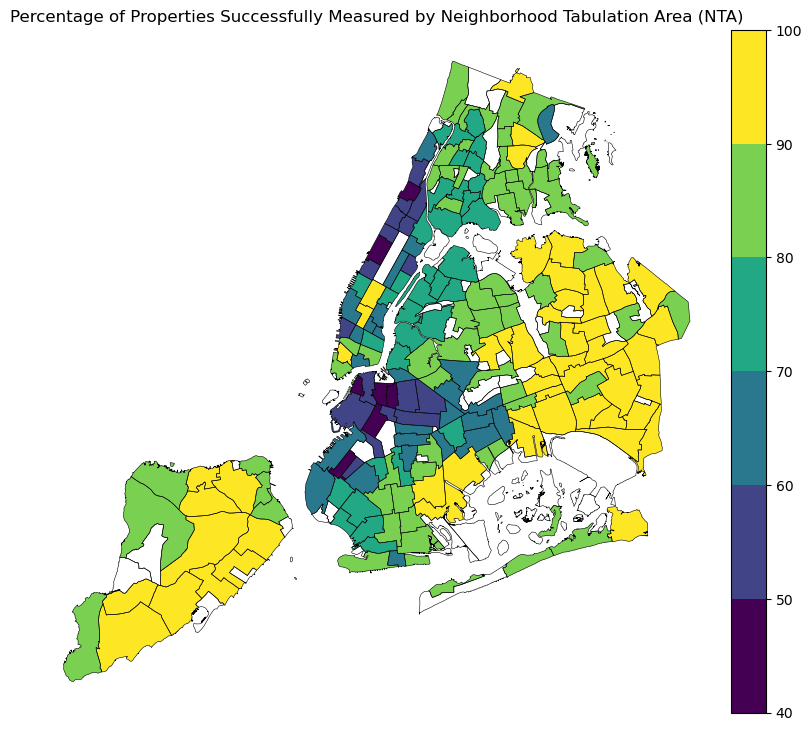

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm([40, 50, 60, 70, 80, 90, 100], cmap.N)

(gdf_merged
.loc[~gdf_merged["nta2020"].isin(nta_exclude)]
.plot(
    column='perc_measured',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax)
)

gdf.plot(ax=ax, facecolor='None', linewidth=.4)

ax.set_title(
    'Percentage of Properties Successfully Measured by Neighborhood Tabulation Area (NTA)',
    fontsize=12
)
ax.axis('off')

plt.tight_layout()
plt.savefig('figures/successfully-measured.png', dpi=250, bbox_inches='tight')

**Figure xx:** Percent of properties that were successfully measured by Neighborhood Tabulation Area (NTA). White areas indicate parks, cemeteries, or other neighborhoods with less than 300 buildings. 